In [2]:
!pip install sliderule

  Using cached sliderule-1.4.4-py3-none-any.whl (75 kB)


In [40]:
# standard imports
import datetime
import pandas as pd

import os
import dask
from dask.diagnostics import ProgressBar
import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import logging
import panel as pn
pn.extension()
import matplotlib.lines
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import shapely.geometry
import warnings
# grimp and nisar functions
# import grimpfunc as grimp
# import nisardev as nisar
# sliderule functions
import sliderule
import sliderule.icesat2
import sliderule.io
import sliderule.ipysliderule

import rioxarray as rxa

import pickle

import glob

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas

# import this to use define sql functions (e.g. postgis!)
from sqlalchemy.sql import func 

# Import this to convert to a rasterio object for easy plotting
from snowexsql.conversions import raster_to_rasterio 

# Import a convenient function to plot with 
import rasterio
from rasterio.plot import show

# register progress bar and set workers
ProgressBar().register()
dask.config.set(num_workers=2)
# turn off warnings for demo
warnings.filterwarnings('ignore')

## Load IS2 snow depth data

In [19]:
# Polygon of Grand Mesa boundary
out_fp = "../../data/IS2_snow_depth.pkl"
gdf3 = pickle.load(open(out_fp, 'rb'))
gdf3 = gdf3[abs(gdf3["diff"]) < 20]
gdf3["snow_presence"] = gdf3["snow_presence"].astype(float)
gdf3.head(3)

time       h_mean  \
time                                                                       
2018-11-15 21:07:35.507301452 2018-11-15 21:07:35.507301452  2980.594716   
2018-11-15 21:07:35.510113648 2018-11-15 21:07:35.510113648  2980.577977   
2018-11-15 21:07:35.512926608 2018-11-15 21:07:35.512926608  2980.610419   

                               rms_misfit    delta_time   h_sigma  rgt  \
time                                                                     
2018-11-15 21:07:35.507301452    0.141154  2.755126e+07  0.025316  737   
2018-11-15 21:07:35.510113648    0.163428  2.755126e+07  0.043345  737   
2018-11-15 21:07:35.512926608    0.141337  2.755126e+07  0.029030  737   

                               n_fit_photons  pflags  dh_fit_dx  spot  ...  \
time                                                                   ...   
2018-11-15 21:07:35.507301452             34       0   0.009144     6  ...   
2018-11-15 21:07:35.510113648             20       0  -0.002196     6  ...   
2018-11-15 21:07:35.512926608             38       0  -0.000247     6  ...   

                                day        lat         lon   lidar_elev  \
time                                                                      
2018-11-15 21:07:35.507301452  15.0  38.991887 -108.113899  2980.455078   
2018-11-15 21:07:35.510113648  15.0  38.992066 -108.113920  2980.770020   
2018-11-15 21:07:35.512926608  15.0  38.992246 -108.113942  2980.858887   

                                   diff  doy      decyear  dowy  \
time                                                              
2018-11-15 21:07:35.507301452  0.139638  319  2018.873645    46   
2018-11-15 21:07:35.510113648 -0.192042  319  2018.873645    46   
2018-11-15 21:07:35.512926608 -0.248467  319  2018.873645    46   

                               snow_presence  diff_corr  
time                                                     
2018-11-15 21:07:35.507301452            1.0   0.094005  
2018-11-15 21:07:35.510113648            1.0  -0.237674  
2018-11-15 21:07:35.512926608            1.0  -0.294099  

[3 rows x 29 columns]

In [20]:
gdf3 = gdf3.rename(columns={"diff": "sd"})
gdf3.keys()

Index(['time', 'h_mean', 'rms_misfit', 'delta_time', 'h_sigma', 'rgt',
       'n_fit_photons', 'pflags', 'dh_fit_dx', 'spot',
       'w_surface_window_final', 'gt', 'segment_id', 'cycle', 'dh_fit_dy',
       'distance', 'geometry', 'year', 'month', 'day', 'lat', 'lon',
       'lidar_elev', 'sd', 'doy', 'decyear', 'dowy', 'snow_presence',
       'diff_corr'],
      dtype='object')

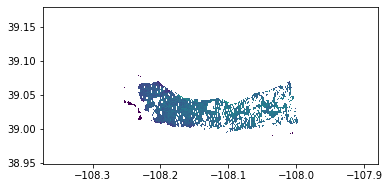

<AxesSubplot:>

In [33]:
file = "SD_02_19.tif"
src02 = rasterio.open(file)
array02 = src02.read(1)
trsform02 = src02.transform
lon, lat = trsform02 * (0,0)
show(src02, vmin = 0, vmax = 2)

In [22]:
# Sample ASO DEM with ATL08 geodataframe
def sample_raster(df, src, diff_col=None):
    #df_proj = df.to_crs(src.crs)
    coord = [(pt.x, pt.y) for pt in df.to_crs(src.crs).geometry]
    s = np.fromiter(src.sample(coord), dtype=src.dtypes[0])
    #s[s == src.nodata] = np.nan
    sm = np.ma.masked_equal(s, src.nodata)
    sm[sm <= 0] = np.nan
    sample_colname = os.path.splitext(os.path.split(src.name)[-1])[0]
    df[sample_colname] = sm
    if diff_col is not None:
        out_colname = 'diff_UAV'
        df[out_colname] = df[diff_col] - df[sample_colname]
        return df
    else:
        out_colname = sample_colname
        return out_colname

In [27]:
t1 = datetime.datetime(2020, 2, 1)
t2 = datetime.datetime(2020, 3, 1)
t_win = (gdf3.index >= t1) & (gdf3.index <= t2)

gdf_02 = sample_raster(gdf3[t_win], src02, diff_col= "sd")
gdf_02.head(3)

time       h_mean  \
time                                                                       
2020-02-12 23:26:20.887750216 2020-02-12 23:26:20.887750216  3027.211171   
2020-02-12 23:26:20.898124544 2020-02-12 23:26:20.898124544  3182.068258   
2020-02-12 23:26:20.899715792 2020-02-12 23:26:20.899715792  2991.773452   

                               rms_misfit    delta_time   h_sigma  rgt  \
time                                                                     
2020-02-12 23:26:20.887750216    0.116278  6.678518e+07  0.017354  737   
2020-02-12 23:26:20.898124544    0.173172  6.678518e+07  0.026657  737   
2020-02-12 23:26:20.899715792    0.174062  6.678518e+07  0.017668  737   

                               n_fit_photons  pflags  dh_fit_dx  spot  ...  \
time                                                                   ...   
2020-02-12 23:26:20.887750216             74       0  -0.002138     4  ...   
2020-02-12 23:26:20.898124544             54       0  -0.007607     6  ...   
2020-02-12 23:26:20.899715792             98       0   0.003854     2  ...   

                                      lon   lidar_elev        sd  doy  \
time                                                                    
2020-02-12 23:26:20.887750216 -108.040610  3026.541260  0.669912   43   
2020-02-12 23:26:20.898124544 -108.077182  3181.118896  0.949362   43   
2020-02-12 23:26:20.899715792 -108.004246  2991.012939  0.760513   43   

                                   decyear  dowy snow_presence  diff_corr  \
time                                                                        
2020-02-12 23:26:20.887750216  2020.117422   135           1.0   0.624280   
2020-02-12 23:26:20.898124544  2020.117422   135           1.0   0.903730   
2020-02-12 23:26:20.899715792  2020.117422   135           1.0   0.714881   

                               SD_02_19  diff_UAV  
time                                               
2020-02-12 23:26:20.887750216       NaN       NaN  
2020-02-12 23:26:20.898124544  0.824462    0.1249  
2020-02-12 23:26:20.899715792       NaN       NaN  

[3 rows x 31 columns]

Mean snow depth (IS2): 0.893 m
Mean snow depth (UAVSAR): 0.732 m


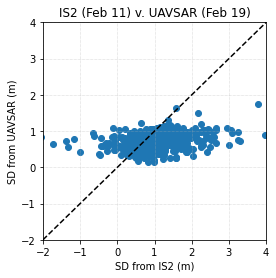

In [72]:
plt.subplots(1, 1, figsize = (4, 4))
plt.scatter(gdf_02["sd"], gdf_02["SD_02_19"])
vmin, vmax = -2, 4

plt.plot([vmin, vmax], [vmin, vmax], c = "k", ls = "--")
plt.xlim(vmin, vmax)
plt.xlabel("SD from IS2 (m)")
plt.ylim(vmin, vmax)
plt.ylabel("SD from UAVSAR (m)")
plt.title("IS2 (Feb 11) v. UAVSAR (Feb 19)")
plt.grid(ls = ":", lw = 0.5)

print("Mean snow depth (IS2): {0:.3f} m".format(gdf_02["sd"].mean()))
print("Mean snow depth (UAVSAR): {0:.3f} m".format(gdf_02["SD_02_19"].mean()))

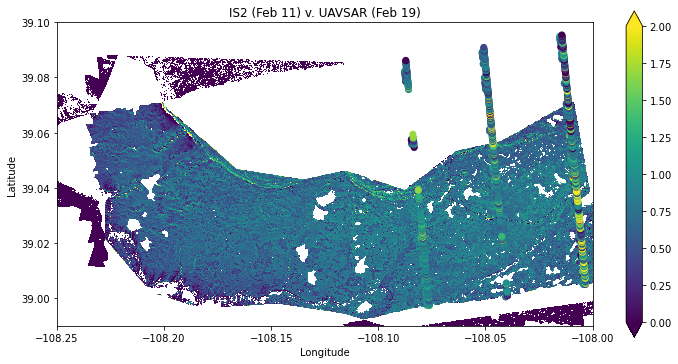

In [68]:
# Create figures and subplots
fig, ax = plt.subplots(1, 1, figsize = (12,6))

img = rxa.open_rasterio('SD_02_19.tif')
vmin, vmax = 0, 2
cmap = "viridis"
img.plot(ax = ax, vmin = vmin, vmax = vmax, cmap = cmap)
gdf_02.plot(ax = ax, column = 'sd', cmap = cmap, vmin = vmin, vmax = vmax)
ax.set_xlim(-108.25,-108)
ax.set_ylim(38.99, 39.1)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("IS2 (Feb 11) v. UAVSAR (Feb 19)")
plt.show()

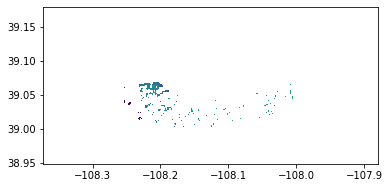

<AxesSubplot:>

In [34]:
file = "SD_03_12.tif"
src03 = rasterio.open(file)
array03 = src03.read(1)
trsform03 = src03.transform
lon, lat = trsform03 * (0,0)
show(src03, vmin = 0, vmax = 2)

In [35]:
t1 = datetime.datetime(2020, 3, 1)
t2 = datetime.datetime(2020, 3, 31)
t_win = (gdf3.index >= t1) & (gdf3.index <= t2)

gdf_03 = sample_raster(gdf3[t_win], src03, diff_col= "sd")
gdf_03.head(3)

time       h_mean  \
time                                                                       
2020-03-11 10:20:29.290021520 2020-03-11 10:20:29.290021520  2715.252240   
2020-03-11 10:20:29.292864440 2020-03-11 10:20:29.292864440  2711.223634   
2020-03-11 10:20:29.298545552 2020-03-11 10:20:29.298545552  2708.386755   

                               rms_misfit    delta_time   h_sigma   rgt  \
time                                                                      
2020-03-11 10:20:29.290021520    0.426794  6.915723e+07  0.134246  1156   
2020-03-11 10:20:29.292864440    0.381953  6.915723e+07  0.180744  1156   
2020-03-11 10:20:29.298545552    0.287485  6.915723e+07  0.087916  1156   

                               n_fit_photons  pflags  dh_fit_dx  spot  ...  \
time                                                                   ...   
2020-03-11 10:20:29.290021520             14       0  -0.194401     6  ...   
2020-03-11 10:20:29.292864440             12       0  -0.210440     6  ...   
2020-03-11 10:20:29.298545552             17       0  -0.070034     6  ...   

                                lidar_elev        sd  doy      decyear  dowy  \
time                                                                           
2020-03-11 10:20:29.290021520  2713.524902  1.727338   71  2020.192434   163   
2020-03-11 10:20:29.292864440  2711.376953 -0.153319   71  2020.192434   163   
2020-03-11 10:20:29.298545552  2706.479004  1.907751   71  2020.192434   163   

                               snow_presence diff_corr  SD_02_19  diff_UAV  \
time                                                                         
2020-03-11 10:20:29.290021520            1.0  1.681706       NaN       NaN   
2020-03-11 10:20:29.292864440            1.0 -0.198951       NaN       NaN   
2020-03-11 10:20:29.298545552            1.0  1.862119       NaN       NaN   

                               SD_03_12  
time                                     
2020-03-11 10:20:29.290021520       NaN  
2020-03-11 10:20:29.292864440       NaN  
2020-03-11 10:20:29.298545552       NaN  

[3 rows x 32 columns]

Mean snow depth (IS2): 0.638 m
Mean snow depth (UAVSAR): 1.162 m


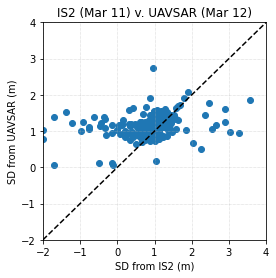

In [71]:
plt.subplots(1, 1, figsize = (4, 4))
plt.scatter(gdf_03["sd"], gdf_03["SD_03_12"])
vmin, vmax = -2, 4

plt.plot([vmin, vmax], [vmin, vmax], c = "k", ls = "--")
plt.xlim(vmin, vmax)
plt.xlabel("SD from IS2 (m)")
plt.ylim(vmin, vmax)
plt.ylabel("SD from UAVSAR (m)")
plt.title("IS2 (Mar 11) v. UAVSAR (Mar 12)")
plt.grid(ls = ":", lw = 0.5)

print("Mean snow depth (IS2): {0:.3f} m".format(gdf_03["sd"].mean()))
print("Mean snow depth (UAVSAR): {0:.3f} m".format(gdf_03["SD_03_12"].mean()))

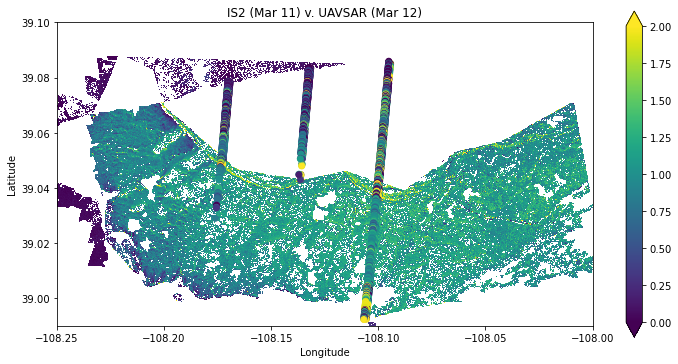

In [69]:
# Create figures and subplots
fig, ax = plt.subplots(1, 1, figsize = (12,6))

img = rxa.open_rasterio('SD_03_12.tif')
vmin, vmax = 0, 2
cmap = "viridis"
img.plot(ax = ax, vmin = vmin, vmax = vmax, cmap = cmap)
gdf_03.plot(ax = ax, column = 'sd', cmap = cmap, vmin = vmin, vmax = vmax)
ax.set_xlim(-108.25,-108)
ax.set_ylim(38.99, 39.1)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_title("IS2 (Mar 11) v. UAVSAR (Mar 12)")

plt.show()

In [ ]:
gdf_mean = gdf3.groupby(["year", "doy"], as_index = False).median()
gdf_mean["diff_std"] = gdf3.groupby(["year", "doy"], as_index = False).std()["diff"]
gdf_mean.index = gdf3.groupby(["year", "doy"], as_index = False).first()["time"]

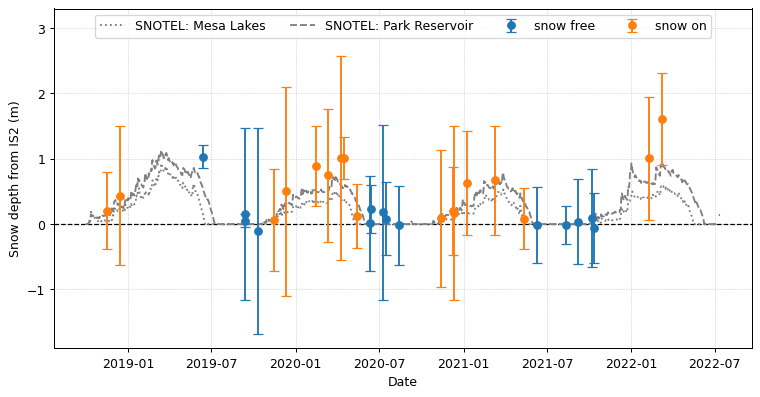

In [406]:
plt.figure(figsize = (10, 5), dpi = 90)
plt.axhline(0, c = "k", ls = "--", lw = 1)

plt.plot(snotel["MesaLakes"]*0.01, label = "SNOTEL: Mesa Lakes", color = "gray", ls = ":")
plt.plot(snotel["ParkReservoir"]*0.01, label = "SNOTEL: Park Reservoir", color = "gray", ls = "--")

labels = ["snow free", "snow on"]
for s in [0, 1]:
    idx = (gdf_mean["snow_presence"] == s)
    # plt.plot(gdf_mean["diff"][idx], 'o')
    # plt.bar(gdf_mean.index[idx], gdf_mean["diff"][idx], yerr=gdf_mean["diff_std"][idx])
    plt.errorbar(gdf_mean.index[idx], gdf_mean["diff"][idx], yerr=gdf_mean["diff_std"][idx],
                 label = labels[s], marker="o", markersize = 6, linestyle="none", capsize = 4)


plt.xlabel("Date")
plt.ylabel("Snow depth from IS2 (m)")
plt.grid(ls = ":", lw = 0.5)
plt.legend(ncol = 4, loc = "upper center")
plt.ylim(-1.9, 3.3)
plt.show()

In [25]:
t1 = datetime.datetime(2020, 2, 1)
t2 = datetime.datetime(2020, 3, 1)
t_win = (gdf3.index >= t1) & (gdf3.index <= t2)
gdf4 = gdf3[t_win]

gdf4.head(3)

time       h_mean  \
time                                                                       
2020-02-12 23:26:20.887750216 2020-02-12 23:26:20.887750216  3027.211171   
2020-02-12 23:26:20.898124544 2020-02-12 23:26:20.898124544  3182.068258   
2020-02-12 23:26:20.899715792 2020-02-12 23:26:20.899715792  2991.773452   

                               rms_misfit    delta_time   h_sigma  rgt  \
time                                                                     
2020-02-12 23:26:20.887750216    0.116278  6.678518e+07  0.017354  737   
2020-02-12 23:26:20.898124544    0.173172  6.678518e+07  0.026657  737   
2020-02-12 23:26:20.899715792    0.174062  6.678518e+07  0.017668  737   

                               n_fit_photons  pflags  dh_fit_dx  spot  ...  \
time                                                                   ...   
2020-02-12 23:26:20.887750216             74       0  -0.002138     4  ...   
2020-02-12 23:26:20.898124544             54       0  -0.007607     6  ...   
2020-02-12 23:26:20.899715792             98       0   0.003854     2  ...   

                                      lon   lidar_elev        sd  doy  \
time                                                                    
2020-02-12 23:26:20.887750216 -108.040610  3026.541260  0.669912   43   
2020-02-12 23:26:20.898124544 -108.077182  3181.118896  0.949362   43   
2020-02-12 23:26:20.899715792 -108.004246  2991.012939  0.760513   43   

                                   decyear  dowy snow_presence  diff_corr  \
time                                                                        
2020-02-12 23:26:20.887750216  2020.117422   135           1.0   0.624280   
2020-02-12 23:26:20.898124544  2020.117422   135           1.0   0.903730   
2020-02-12 23:26:20.899715792  2020.117422   135           1.0   0.714881   

                               SD_02_19  diff_UAV  
time                                               
2020-02-12 23:26:20.887750216       NaN       NaN  
2020-02-12 23:26:20.898124544  0.824462    0.1249  
2020-02-12 23:26:20.899715792       NaN       NaN  

[3 rows x 31 columns]

In [409]:
unique_dates = gdf3.groupby(["year", "doy"], as_index = False).first()[["year", "doy", "time", "snow_presence"]]

for i, p in enumerate(unique_dates["snow_presence"]):
    if i == 0:
        seq = 0
    else:
        if (p != unique_dates["snow_presence"][i-1]):
            seq += 1
    unique_dates.loc[i, "seq"] = seq
    
unique_dates.head(3)

year  doy                          time  snow_presence  seq
0  2018.0  319 2018-11-15 21:07:35.507301452            1.0  0.0
1  2018.0  347 2018-12-13 08:01:26.372018104            1.0  0.0
2  2019.0  163 2019-06-12 23:21:03.295344704            0.0  1.0

In [410]:
for i,k in enumerate(range(len(unique_dates))):
    
    idx = (gdf3["year"] == unique_dates.loc[i, "year"]) & (gdf3["doy"] == unique_dates.loc[i, "doy"])
    gdf3.loc[idx, "seq"] = unique_dates.loc[i, "seq"]
    
gdf3.tail(3)

time       h_mean  \
time                                                                       
2022-03-07 23:39:20.731628864 2022-03-07 23:39:20.731628864  3177.347620   
2022-03-07 23:39:20.734443568 2022-03-07 23:39:20.734443568  3177.272823   
2022-03-07 23:39:20.737259424 2022-03-07 23:39:20.737259424  3177.338975   

                               rms_misfit    delta_time   h_sigma   rgt  \
time                                                                      
2022-03-07 23:39:20.731628864    0.133648  1.319316e+08  0.021721  1156   
2022-03-07 23:39:20.734443568    0.127930  1.319316e+08  0.017406  1156   
2022-03-07 23:39:20.737259424    0.113893  1.319316e+08  0.018103  1156   

                               n_fit_photons  pflags  dh_fit_dx  spot  ...  \
time                                                                   ...   
2022-03-07 23:39:20.731628864             38       0  -0.003295     4  ...   
2022-03-07 23:39:20.734443568             56       0  -0.003190     4  ...   
2022-03-07 23:39:20.737259424             51       0   0.009797     4  ...   

                                     lat         lon   lidar_elev      diff  \
time                                                                          
2022-03-07 23:39:20.731628864  38.998653 -108.078055  3175.402100  1.945521   
2022-03-07 23:39:20.734443568  38.998473 -108.078077  3175.211914  2.060909   
2022-03-07 23:39:20.737259424  38.998293 -108.078098  3175.371094  1.967882   

                               doy      decyear dowy  snow_presence  \
time                                                                  
2022-03-07 23:39:20.731628864   66  2022.180783  158            1.0   
2022-03-07 23:39:20.734443568   66  2022.180783  158            1.0   
2022-03-07 23:39:20.737259424   66  2022.180783  158            1.0   

                               diff_corr  seq  
time                                           
2022-03-07 23:39:20.731628864   1.899889  6.0  
2022-03-07 23:39:20.734443568   2.015277  6.0  
2022-03-07 23:39:20.737259424   1.922250  6.0  

[3 rows x 30 columns]

0 0.0
1 1.0
2 2.0
3 3.0
4 4.0
5 5.0
6 6.0


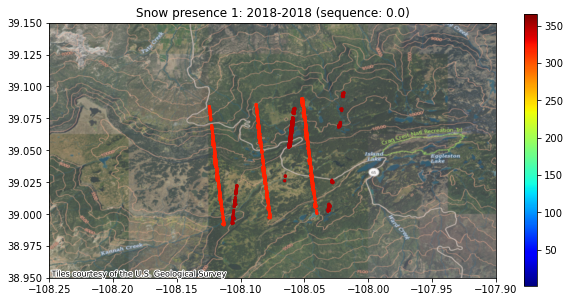

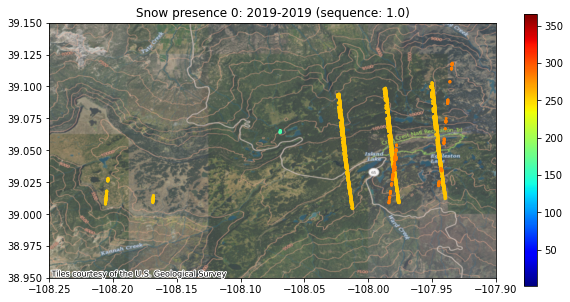

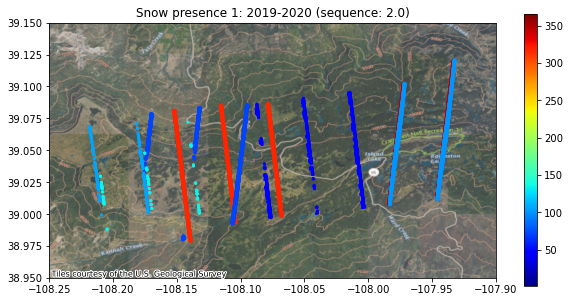

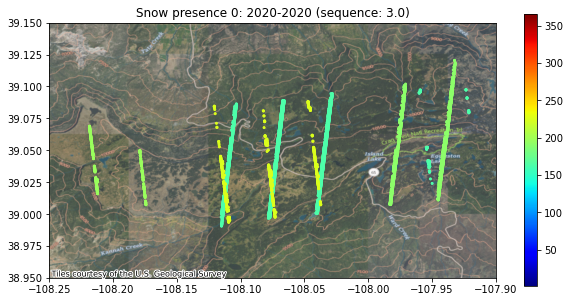

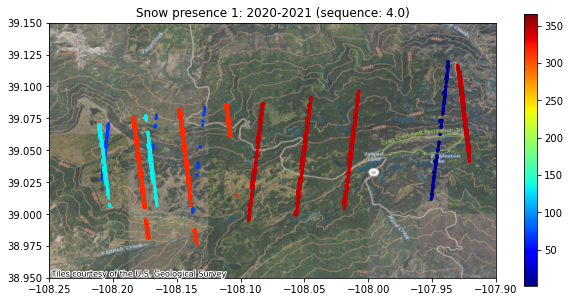

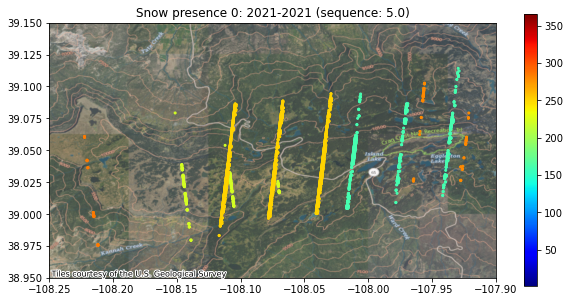

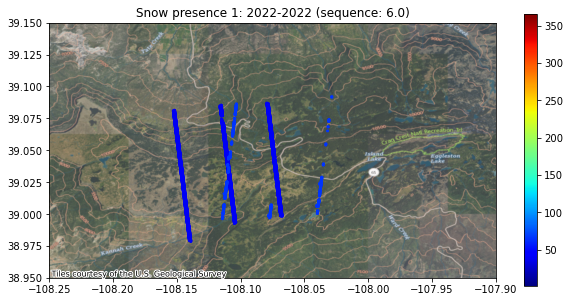

In [413]:
   
    
data_dir = '/tmp/uavsar-tutorial-data/'
img = rxa.open_rasterio(join(data_dir, f'cor.tif'))

for i,s in enumerate(np.unique(unique_dates["seq"])):
    
    fig, ax = plt.subplots(1, 1, figsize= (10, 5))
    
    print(i, s)
    subset = gdf3[gdf3["seq"] == s]
    # subset.plot(ax = ax, column = 'diff', legend = True, cmap = 'RdBu_r', vmin = -2, vmax = 2)
    subset.plot(ax = ax, column = 'doy', legend = True, markersize = 4, cmap = "jet", vmin = 1, vmax = 365)

    # Set same bounds as uavsar image plot
    ax.set_xlim(-108.25,-107.9)
    ax.set_ylim(38.95, 39.15)

    # Add background map
    # cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USTopo)
    cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USImageryTopo)
    ax.set_title("Snow presence {0}: {1}-{2} (sequence: {3})".format(int(subset.head(1)["snow_presence"].values[0]),
                                                    int(subset.head(1)["year"].values[0]),
                                                    int(subset.tail(1)["year"].values[0]),
                                                    s))

0 2


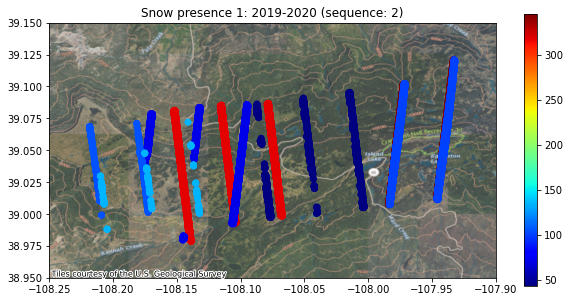

In [414]:
for i,s in enumerate([2]):
    
    fig, ax = plt.subplots(1, 1, figsize= (10,5))
    
    print(i, s)
    subset = gdf3[gdf3["seq"] == s]
    # subset.plot(ax = ax, column = 'diff', legend = True, cmap = 'RdBu_r', vmin = -2, vmax = 2)
    subset.plot(ax = ax, column = 'doy', legend = True, cmap = "jet")

    # Set same bounds as uavsar image plot
    ax.set_xlim(-108.25,-107.9)
    ax.set_ylim(38.95, 39.15)

    # Add background map
    # cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USTopo)
    cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USImageryTopo)
    ax.set_title("Snow presence {0}: {1}-{2} (sequence: {3})".format(int(subset.head(1)["snow_presence"].values[0]),
                                                    int(subset.head(1)["year"].values[0]),
                                                    int(subset.tail(1)["year"].values[0]),
                                                    s))

In [359]:
np.unique(subset["doy"])
# comparison pairs: (345, 100) - overlapped; (318, 71) - crossing

array([ 43,  71, 100, 105, 134, 318, 345])

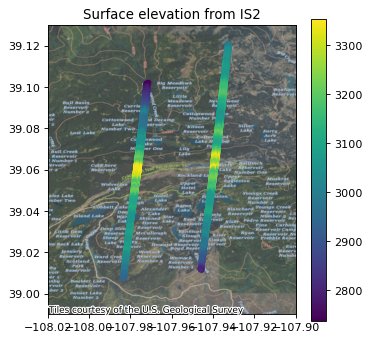

In [529]:
track1 = subset[subset["doy"] == 345]
track2 = subset[subset["doy"] == 100]

fig, ax = plt.subplots(1, 1, figsize= (5,5), dpi = 80)

track1.plot(ax = ax, column = 'h_mean', legend = True, cmap = "viridis", markersize = 10)
track2.plot(ax = ax, column = 'h_mean', cmap = "viridis", markersize = 10)

# Set same bounds as uavsar image plot
ax.set_xlim(-108.02,-107.9)
ax.set_ylim(38.99, 39.13)
ax.set_title("Surface elevation from IS2")

# Add background map
# cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USTopo)
cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USImageryTopo)

Snow depth first date:  0.6450575382595972
Snow depth first date:  1.115072889930695
Mean difference of snow depth: 0.4700 m


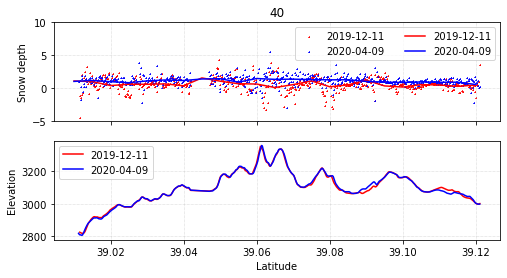

In [532]:
# Check overlapping tracks
def resample_is2(gdf, lat1, lat2, step, field = "diff"):
    lats = np.arange(lat1, lat2+step, step)
    output = np.zeros(len(lats))
    for i, L in enumerate(lats):
        value = gdf.loc[(gdf["lat"] >= L) & (gdf["lat"] <= L+step), field].median()
        output[i] = value
    return lats, output     

gt = 40 # 40, 60
xfield = "lat"
yfield = "diff"

fig, ax = plt.subplots(2, 1, figsize = (8, 4), sharex = True)
idx1 = (track1["gt"] == gt) & ((track1["lat"] > 39.047) | (track1["lat"] < 39.042))
idx2 = (track2["gt"] == gt) & ((track2["lat"] > 39.047) | (track2["lat"] < 39.042))
ax[0].scatter(track1[xfield][idx1], track1[yfield][idx1], s = 1, marker = "+", label = track1["time"][0].strftime("%Y-%m-%d"), color = "r")
ax[0].scatter(track2[xfield][idx2], track2[yfield][idx2], s = 1, marker = "+", label = track2["time"][0].strftime("%Y-%m-%d"), color = "b")

lats, res1 = resample_is2(track1[idx1], 39.0, 39.12, 0.005, field = "diff")
lats, res2 = resample_is2(track2[idx2], 39.0, 39.12, 0.005, field = "diff")

ax[0].plot(lats, res1, label = track1["time"][0].strftime("%Y-%m-%d"), color = "r")
ax[0].plot(lats, res2, label = track2["time"][0].strftime("%Y-%m-%d"), color = "b")

ax[0].grid(ls = ":", lw = 0.5)
ax[0].set_ylim(-5, 10)
ax[0].set_ylabel("Snow depth")
ax[0].legend(ncol = 2)
ax[0].set_title(gt)

print("Snow depth first date: ", np.nanmean(res1))
print("Snow depth first date: ", np.nanmean(res2))
print("Mean difference of snow depth: {0:.4f} m".format(np.nanmean(res2- res1)))

# Plot elevation =======================================
yfield = "h_mean"
ax[1].plot(track1[xfield][idx1], track1[yfield][idx1], label = track1["time"][0].strftime("%Y-%m-%d"), color = "r")
ax[1].plot(track2[xfield][idx2], track2[yfield][idx2], label = track2["time"][0].strftime("%Y-%m-%d"), color = "b")

ax[1].grid(ls = ":", lw = 0.5)
ax[1].legend()
ax[1].set_ylabel("Elevation")
ax[1].set_xlabel("Latitude")
plt.show()

Snow depth first date:  0.45624360335864367
Snow depth first date:  0.9342884515108267
Mean difference of snow depth: 0.4780 m


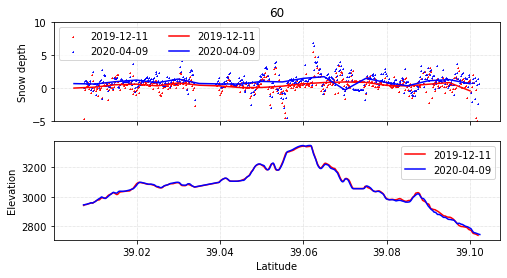

In [533]:
gt = 60 # 40, 60
xfield = "lat"
yfield = "diff"

fig, ax = plt.subplots(2, 1, figsize = (8, 4), sharex = True)
idx1 = (track1["gt"] == gt) & ((track1["lat"] > 39.039) | (track1["lat"] < 39.034))
idx2 = (track2["gt"] == gt) & ((track2["lat"] > 39.039) | (track2["lat"] < 39.034))
ax[0].scatter(track1[xfield][idx1], track1[yfield][idx1], s = 1, marker = "+", label = track1["time"][0].strftime("%Y-%m-%d"), color = "r")
ax[0].scatter(track2[xfield][idx2], track2[yfield][idx2], s = 1, marker = "+", label = track2["time"][0].strftime("%Y-%m-%d"), color = "b")

lats, res1 = resample_is2(track1[idx1], 39.0, 39.12, 0.005, field = "diff")
lats, res2 = resample_is2(track2[idx2], 39.0, 39.12, 0.005, field = "diff")

ax[0].plot(lats, res1, label = track1["time"][0].strftime("%Y-%m-%d"), color = "r")
ax[0].plot(lats, res2, label = track2["time"][0].strftime("%Y-%m-%d"), color = "b")

ax[0].grid(ls = ":", lw = 0.5)
ax[0].set_ylim(-5, 10)
ax[0].set_ylabel("Snow depth")
ax[0].legend(ncol = 2)
ax[0].set_title(gt)

print("Snow depth first date: ", np.nanmean(res1))
print("Snow depth first date: ", np.nanmean(res2))
print("Mean difference of snow depth: {0:.4f} m".format(np.nanmean(res2- res1)))

# Plot elevation =======================================
yfield = "h_mean"
ax[1].plot(track1[xfield][idx1], track1[yfield][idx1], label = track1["time"][0].strftime("%Y-%m-%d"), color = "r")
ax[1].plot(track2[xfield][idx2], track2[yfield][idx2], label = track2["time"][0].strftime("%Y-%m-%d"), color = "b")

ax[1].grid(ls = ":", lw = 0.5)
ax[1].legend()
ax[1].set_ylabel("Elevation")
ax[1].set_xlabel("Latitude")
plt.show()

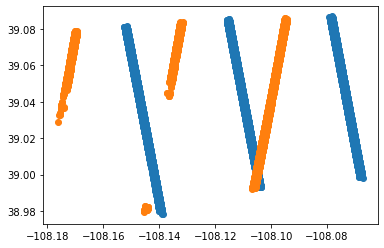

In [496]:
# Compare crossing tracks (318 & 71)
track1 = subset[subset["doy"] == 318]
track2 = subset[subset["doy"] == 71]

plt.scatter(track1["lon"], track1["lat"])
plt.scatter(track2["lon"], track2["lat"])

Snow depth difference:  1.4529613724172867


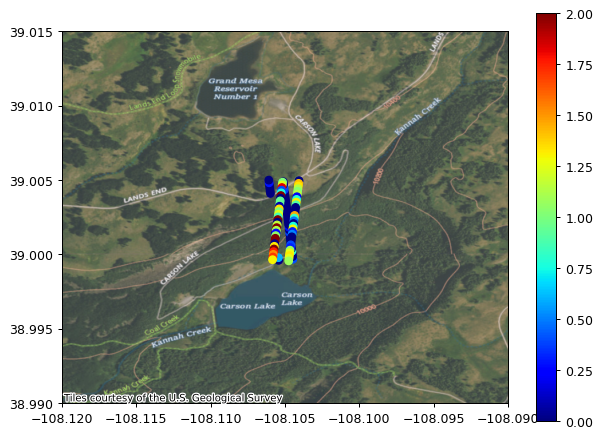

In [497]:
def area_snowdepth(track, bbox):
    sampled = track[(track["lon"] > bbox[0]) & (track["lon"] < bbox[2])]
    sampled = sampled[(sampled["lat"] > bbox[1]) & (sampled["lat"] < bbox[3])]
    return sampled

bbox = [-108.12, 38.9995, -108.10, 39.005]

sampled1 = area_snowdepth(track1, bbox)
sampled2 = area_snowdepth(track2, bbox)

sd1 = sampled1.mean()["diff"]
sd2 = sampled2.mean()["diff"]
print("Snow depth difference: ", sd2-sd1)

fig, ax = plt.subplots(1, 1, figsize= (8,6), dpi = 90)
    
sampled1.plot(ax = ax, column = 'diff', legend = True, cmap = "jet", vmin = 0, vmax = 2)
sampled2.plot(ax = ax, column = 'diff', cmap = "jet", vmin = 0, vmax = 2)

# Set same bounds as uavsar image plot
ax.set_xlim(-108.12,-108.09)
ax.set_ylim(38.99, 39.015)

# Add background map
# cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USTopo)
cx.add_basemap(ax, crs=img.rio.crs, alpha = 0.8, source = cx.providers.USGS.USImageryTopo)

In [528]:
print(snotel.loc[snotel.index == datetime.datetime(2019, 12, 1)])
print(snotel.loc[snotel.index == datetime.datetime(2020, 4, 9)])
# print(snotel.index[0], snotel.loc[snotel.index[44], "MesaLakes"])
# print(snotel.index[190], snotel.loc[snotel.index[190], "MesaLakes"])


                  Date  MesaLakes  ParkReservoir       Time
Time                                                       
2019-12-01  2019-12-01       16.0           30.0 2019-12-01
                  Date  MesaLakes  ParkReservoir       Time
Time                                                       
2020-04-09  2020-04-09       38.0           59.0 2020-04-09
